In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import sys, string, os
import subprocess

In [19]:
class Rain_random_graph:
    def __init__(self, p: float = None, bound: int = None, time: int = -1):
        self.time = time
        self.p = p
        self.bound = bound
        self.H = []
        self.clients = []
        self.edges = []
        if self.time != -1 and self.time > 0:
            self.clients = [np.random.binomial(1, self.p, 2*self.bound + 1) for _ in range(self.time)]
            self.edges = [np.full(2*self.bound + 1, None) for _ in range(self.time)]
            for i in range(1, self.time+1):
                for j in range(2*bound+1):
                    self.generate_node_edges([j, i])
            self.H = [np.full(2*self.bound + 1, None) for _ in range(time)]
        self.arrow_width = 0.001
        self.arrow_head_width = 0.2
        self.arrow_head_length = 0.2
        self.EPS = 0.23
                        
    def generate_node_edges(self, grid_index: list):
        server = grid_index[0]
        time = grid_index[1] - 1
        node_edges = []      
        if not self.lazy:
            server = grid_index[0]
            time = grid_index[1] - 1
            if self.clients[time][server] == 0:
                node_edges = [None, None, None, None]
            else:
                if time > 0:
                    if server > 0:
                        if self.clients[time-1][server-1] == 1:
                            node_edges.append(1)
                        else:
                            node_edges.append(None)
                    else:
                        node_edges.append(None)
                        node_edges.append(None)
                    if server < 2*self.bound:
                        if self.clients[time-1][server+1] == 1:
                            node_edges.append(1)
                        else:
                            node_edges.append(None)
                        if self.clients[time][server+1] == 1:
                            node_edges.append(np.random.binomial(1, 0.5))
                        else:
                            node_edges.append(None)
                    else:
                        node_edges.append(None)
                        node_edges.append(None)
                else:
                    node_edges.append(None)
                    if server < 2*self.bound:
                        if self.clients[time][server+1] == 1:
                            node_edges.append(None)
                            node_edges.append(np.random.binomial(1, 0.5))
                        else:
                            node_edges.append(None)
                            node_edges.append(None)
                    else:
                        node_edges.append(None)
                        node_edges.append(None)
            self.edges[time][server] = node_edges
    
    def max_path(self, edge_coord: list = None)->int:
        if edge_coord is None:
            edge_coord = [self.bound, self.time-1]
        server = edge_coord[0]
        time = edge_coord[1]
        if time == -1:
            return 0
        else:
            max_edge_path_d = 0
            max_edge_path_l_u = 0
            max_edge_path_l_d = 0
            max_edge_path_r_d = 0
            max_edge_path_r_u = 0
            if self.H[time][server] is not None:
                return self.H[time][server]
            if time > 0:
                if self.clients[time-1][server] == 1:
                    if self.clients[time][server] == 1:
                        max_edge_path_d = self.max_path([server, time-1]) + 1
                    else:
                        max_edge_path_d = self.max_path([server, time-1])
                else:
                    if self.clients[time][server] == 1:
                        max_edge_path_d = self.max_path([server, time-1]) + 1
                    else:
                        max_edge_path_d = self.max_path([server, time-1])
                if server > 0 and self.edges[time][server-1][2] == 0:
                    max_edge_path_l_u = self.max_path([server-1, time]) + 1
                if self.edges[time][server][0] is not None:
                    max_edge_path_l_d = self.max_path([server-1, time-1]) + 1
                if self.edges[time][server][1] is not None:
                    max_edge_path_r_d = self.max_path([server+1, time-1]) + 1
                if self.edges[time][server][2] == 1:
                    max_edge_path_r_u = self.max_path([server+1, time]) + 1                   
                self.H[time][server] = max(max_edge_path_d,
                                   max_edge_path_l_u,
                                   max_edge_path_l_d,
                                   max_edge_path_r_d,
                                   max_edge_path_r_u)
                return self.H[time][server]
            else:
                if self.clients[time][server] == 1:
                    if not (server > 0 and self.edges[time][server-1][2] == 0) and not self.edges[time][server][2] == 1:
                        self.H[time][server] = 1
                        return self.H[time][server]
                    else:
                        max_edge_path_l_u = 0
                        max_edge_path_r_u = 0
                        if server > 0 and self.edges[time][server-1][2] == 0:
                            max_edge_path_l_u = self.max_path([server-1, time]) + 1
                        if self.edges[time][server][2] == 1:
                            max_edge_path_r_u = self.max_path([server+1, time]) + 1
                        self.H[time][server] = max(max_edge_path_l_u, max_edge_path_r_u)
                        return self.H[time][server]
                else:
                    self.H[time][server] = 0
                    return self.max_path([server, time-1])
    
    def draw_graph(self, max_path_coord: list = None):
        plt.rcParams['figure.figsize'] = [20, 10]
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_xticks(np.arange(-self.bound,self.bound+1,1))
        ax.set_yticks(np.arange(0,self.time+1,1))
        arrow_width = self.arrow_width
        arrow_head_width = self.arrow_head_width
        arrow_head_length = self.arrow_head_length
        EPS = self.EPS
        for i in range(2*self.bound+1):
            for j in range(self.time):
                if self.clients[j][i] == 1:
                    ax.plot([i - self.bound], [j+1], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")
                else:
                    ax.plot([i - self.bound], [j+1], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="white")
        for i in range(2*self.bound+1):
            for j in range(self.time):
                pass
                if j != 0:
                    ax.arrow(i - self.bound, j+1, 0, -1, width = arrow_width, 
                          head_width = 0, head_length=0, overhang = 1, ec ='blue')
                if self.edges[j][i][0] is not None:
                    ax.arrow(i - self.bound, j+1, -1, -1, width = arrow_width, 
                              head_width = 0, head_length=0, overhang = 1, ec ='blue')
                if self.edges[j][i][1] is not None:
                    ax.arrow(i - self.bound, j+1, 1, -1, width = arrow_width, 
                              head_width = 0, head_length=0, overhang = 1, ec ='blue')
                if self.edges[j][i][2] is not None:
                    if self.edges[j][i][2] == 1:
                        ax.arrow(i - self.bound, j+1, (1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length, overhang = 1, ec ='blue')
                    else:
                        ax.arrow(i - self.bound + 1, j+1, -(1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length, overhang = 1, ec ='blue')
                        
        if max_path_coord is not None:
            self.max_path([max_path_coord[0] + self.bound, max_path_coord[1] - 1])
            server = max_path_coord[0] + self.bound
            time = max_path_coord[1] - 1
            while time >= 0:
                if server > 0 and self.edges[time][server-1][2] == 0 and self.H[time][server-1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, -(1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server - 1
                    continue
                if server > 0 and time > 0 and self.edges[time][server][0] is not None and self.H[time-1][server-1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, -(1 - EPS), -(1 - EPS), width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server - 1
                    time = time - 1
                    continue
                if server < 2*self.bound and time > 0 and self.edges[time][server][1] is not None and self.H[time-1][server+1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, (1 - EPS), -(1 - EPS), width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server + 1
                    time = time - 1
                    continue
                if server < 2*self.bound and self.edges[time][server][2] is not None and self.H[time][server+1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, (1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server + 1
                    continue
                if time > 0:
                    ax.arrow(server - self.bound, time+1, 0, -(1 - 1.2*EPS), width = arrow_width, 
                    head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    time = time - 1
                    continue
                time = time - 1
                
        plt.show()   
    
    def f_max_paths(self, verbose=False)->dict:
        process = subprocess.Popen("rrg_fixed_size/build-Debug/bin/rrg_fixed_size", stdout=subprocess.PIPE)
        if verbose:
            for line in iter(process.stdout.readline, b''):
                sys.stdout.write(line)
        
        rrg_data = dict()
        rrg_data_dir = "rrg_moduled_data"
        rrg_data_files = os.listdir(rrg_data_dir)
        for file in rrg_data_files:
            if (file.endswith('.txt')):
                with open(rrg_data_dir + '/' + file, 'r', encoding= 'unicode_escape') as f:
                    rrg_data_list = f.readline().split(',')
                    rrg_data[file] = list(map(int, rrg_data_list[:len(rrg_data_list)-1]))
        
        return rrg_data


In [20]:
rrg = Rain_random_graph()
rrg_data = rrg.f_max_paths()

Iteration: 1
1919
Iteration: 2
1919
Iteration: 3
1968
Iteration: 4
1915
Iteration: 5
1949
Iteration: 6
1914
Iteration: 7
1932
Iteration: 8
1978
Iteration: 9
1945
Iteration: 10
1924
Iteration: 11
1920
Iteration: 12
1932
Iteration: 13
1919
Iteration: 14
1925
Iteration: 15
1954
Iteration: 16
1924
Iteration: 17
1942
Iteration: 18
1907
Iteration: 19
1949
Iteration: 20
1907
Iteration: 21
1933
Iteration: 22
1935
Iteration: 23
1938
Iteration: 24
1916
Iteration: 25
1969
Iteration: 26
1966
Iteration: 27
1935
Iteration: 28
1912
Iteration: 29
1907
Iteration: 30
1920
Iteration: 31
1923
Iteration: 32
1950
Iteration: 33
1918
Iteration: 34
1931
Iteration: 35
1904
Iteration: 36
1915
Iteration: 37
1922
Iteration: 38
1922
Iteration: 39
1900
Iteration: 40
1926
Iteration: 41
1947
Iteration: 42
1938
Iteration: 43
1923
Iteration: 44
1922
Iteration: 45
1932
Iteration: 46
1938
Iteration: 47
1955
Iteration: 48
1982
Iteration: 49
1926
Iteration: 50
1940
Iteration: 51
1974
Iteration: 52
1930
Iteration: 53
1934
It

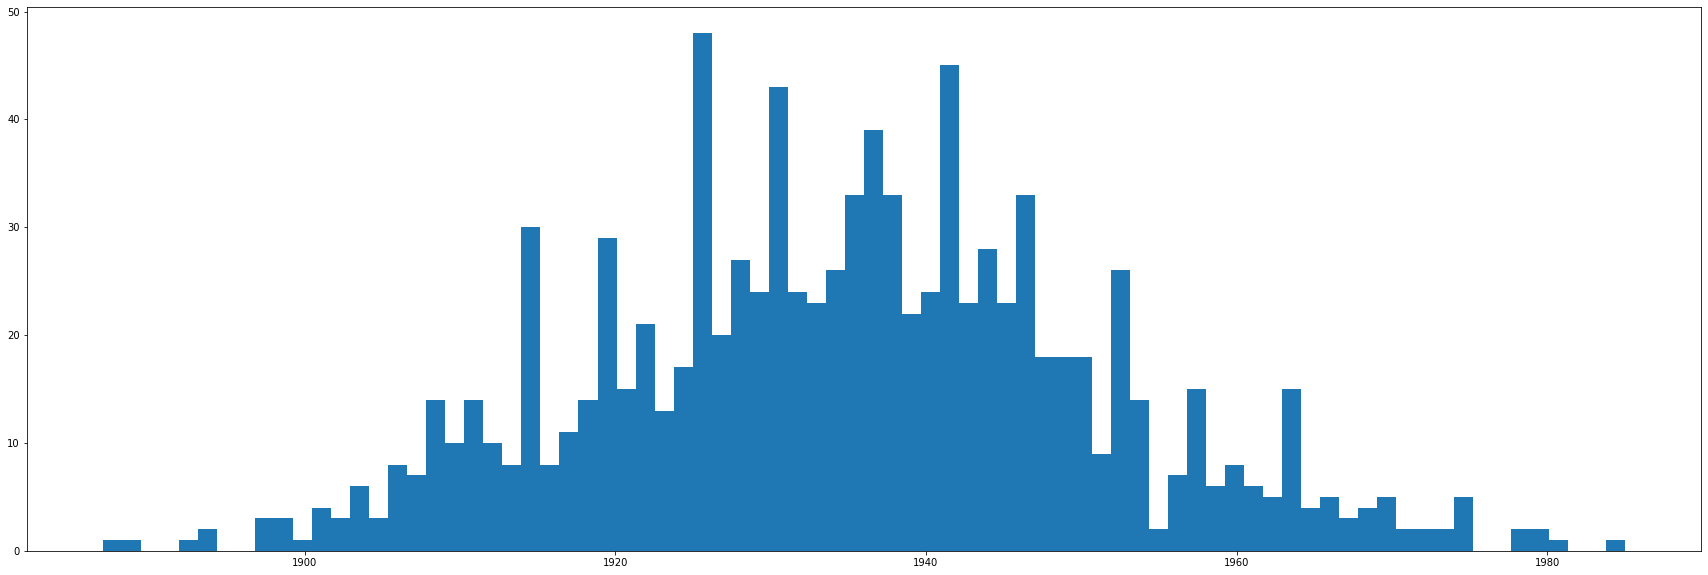

In [30]:
data_p_t = rrg_data[next(iter(rrg_data))]

plt.figure(figsize=(30, 10))
plt.hist(data_p_t, bins=80)
plt.show()